# Gray Level Co-occurrence Matrices (GLCM)

In this notebook, we will demonstrate how to use Gray Level Co-occurrence Matrices (GLCM), also known as _haralick features_, to perform texture analysis with PyImageJ. To learn more on GLCM and its applications, please visit [GLCM wikipedia](https://en.wikipedia.org/wiki/Co-occurrence_matrix) page. 

In this example, we will work with a 2D image (shape: `(500, 500)`) of HeLa cells infected with HIV<sub>NL4-3</sub> expressing [mVenus](https://www.fpbase.org/protein/mvenus/) tagged Gag polyprotein. The field of view contains 4 cells, 3 of which are at _below_ the cooperative threshold for Gag assembly (_i.e._ the concentration of HIV Gag is too low to multimerize into viral particles at the plasma membrane) and 1 cell at or _above_ the assembly threshold<sup>1</sup>. This workflow extracts 6 crops from the sample image, 4 crops from each of the cells and 2 crops from the background, and computes the GLCM correlation and difference variance values.

![Cells with labels](https://media.imagej.net/pyimagej/doc/images/glcm_cell_label.png)

## Texture analysis with GLCM

The GLCM operation requires 3 parameters, in addition to the input image, that need to be carefully selected. These 3 paramers are _gray levels_, _distance_ and _orientation/angle_. 

### Gray Levels

The number of discrete intensity values to bin the image pixel data into. Typically you want to select a value that is smaller than the max gray value of the image as a power of 2. For example, if your image is 8-bit then the max gray value (_i.e._ the maximum value you can store in an 8-bit address) is 255. Powers of 2 that are smaller than 255 and are good values to select for _gray levels_ for an 8-bit image are:

| 2<sup>_n_</sup> | Value |
| :---:           | :---: |
| 2<sup>1</sup>   | 2     |
| 2<sup>2</sup>   | 4     |
| 2<sup>3</sup>   | 8     |
| 2<sup>4</sup>   | 16    |
| 2<sup>5</sup>   | 32    |
| 2<sup>6</sup>   | 64    |
| 2<sup>7</sup>   | 128   |

### Distance

The distance two pixels should be considered. For fine texutures select small pixel distances like 2. Conversely, for coarser details select a larger distance value 

### Orientation/Angle

GLCM will compare patterns at given angles which can provide you information on the motion of the texture.

### Available GLCM texture analyses in imagej-ops

The `imagej-ops` framework offers the following implementations of GLCM analyses:

- Angular Secondary Moment (ASM)
- Cluster Promenence
- Cluser Shade
- Contrast
- Correlation
- Difference Entropy
- Difference Variance
- Entropy
- Information Measure of Correlation 1 (icm1)
- Information Measure of Correlation 2 (icm2)
- Inverse Difference Moment (ifdm)
- Max Probability
- Sum Average
- Sum Entropy
- Texture Homogeneity
- Variance

### Correlation and Difference Variance GLCM textures

This notebook will use two textures _correlation_ and _difference variance_. The _correlation_ texture is a mesure of linear gray level dependecy between a given set of pixels. High _correlation_ values indicate there is a strong linear relationship between the gray levels in the image. Conversly, low _correlation_ values indicate a weak linear relationship in the gray levels in the image. Visually a texture with a higher _correlation_ value indicates a smoother or more uniform texture, while a lower value suggests a texture with more rapid changes and variations in pixel intensity.

The _difference variance_ texture is a measure of pixel intensity variation between a given set of pixels. High _difference variance_ values indicate that there is significant pixel intensity variation in the between a given set of gray levels. Low _difference variance_ values indicate that there are fewer transistions between gray level pair values. Visually, a texture with a higher _difference variance_ value may appear noisy, whereas a texture with a lower _difference variance_ value will appear more homogeneous.

With these two textures measurements we can analyze an image and determine how **smooth** and **variable** the images are.

## Using PyImageJ and imagej-ops for GLCM texture analysis

Let's start by first initializing ImageJ2, importing the needed Java resources and configure the GLCM parameters.

In [1]:
import imagej
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import patches

ij = imagej.init(add_legacy=False)
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.14.0


Next we need to import the `MatrixOrientation2D` Java class which cotains angle parameters we can specify. To make it easy to use all four angles (_antidiagonal_, _diagonal_, _horizontal_ and _vertical_), let's load the `MatrixOrientation2D` into a dictionary.

In [2]:
# get Imglib2 resources
MatrixOrientation2D = imagej.sj.jimport('net.imagej.ops.image.cooccurrenceMatrix.MatrixOrientation2D')

# setup orientation dictionary
orientations = {
    "antidiagonal": MatrixOrientation2D.ANTIDIAGONAL,
    "diagonal"    : MatrixOrientation2D.DIAGONAL,
    "horizontal"  : MatrixOrientation2D.HORIZONTAL,
    "vertical"    : MatrixOrientation2D.VERTICAL
}

The following cell will setup the `run_glcm()` and `process_crops()`functions. The `run_glcm()` function accepts a single 2D image, obtains the _correlation_ and _difference variance_ GLCM texture values and returns a tuple. The `process_crops()` function will process a list of crops we will generate later and feed each crop to the `run_glcm()` function and store it's output in a `pandas.DataFrame`. Once we have the `pandas.DataFrame` we can easily plot the data on a scattterplot.

In [3]:
def run_glcm(img, gray_levels: int, dist: int, angle: str):
    """
    Compute the correlation and difference variance GLCM textures from an image.

    :param img: An input ImgPlus
    :param gray_levels: Number of gray levels
    :param dist: Distance in pixels
    :param angle: Angle to analyze image
    :return: A tuple of floats: (correlation, difference variance)
    """
    # compute correlation and difference variance
    corr = ij.op().haralick().correlation(img, gray_levels, dist, orientations.get(angle))
    diff = ij.op().haralick().differenceVariance(img, gray_levels, dist, orientations.get(angle))
    
    # convert to Python float
    corr = ij.py.from_java(corr)
    diff = ij.py.from_java(diff)

    return (corr.value, diff.value)

def process_crops(crops, gray_levels: int, dist: int, angle: str) -> pd.DataFrame:
    """
    Process a list of ImgPlus images with GLCM texture analysis.

    :param crops: A list of ImgPlus images
    :param gray_levels: Number of gray levels
    :param dist: Distance in pixels
    :param angle: Angle to analyze image
    :return: Pandas DataFrame
    """
    # compute the correlation and difference variance for each crop
    glcm_results = []
    for c in crops:
        glcm_results.append(run_glcm(ij.py.to_dataset(c), gray_levels, dist, angle))

    return pd.DataFrame(glcm_results, columns=['corr', 'diff'])

We also need to specify the number of `gray_levels` and the `dist` before we can perform the texture analysis. Here we selected 128 for `gray_levels` and a `dist` of 10.

In [4]:
# setup GLCM parameters
gray_levels = 128 # a value lower than the bit depth of the image and typically a power of 2
dist = 10 # distance in pixels

Now let's load the sample data and view the image.

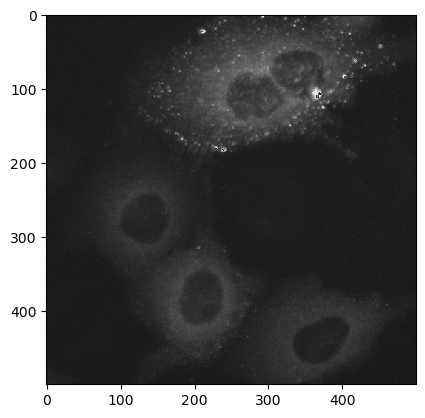

In [5]:
# load sample data from media.imagej.net
data = ij.io().open('https://media.imagej.net/workshops/data/2d/hela_hiv_gag-yfp.tif')

# convert the data to xarray for displaying
data_xarr = ij.py.from_java(data) # convert net.imagej.Dataset to xarray.DataArray
ij.py.show(data_xarr * 12, cmap='Greys_r') # multiply by 12 to better visualize the data (doesn't change source)

Next we want a total of 6 crops of shape `(50, 50)` from specific places in the image. 4 of the 6 crops will be from each cell in the field of view, while the last 2 crops will be extracted from the background. The following cell does 3 things: (1) create a list of crops by slicing* the original data, (2) store the min x and min y coordinates, (3) display the crops in a 2 x 3 matplotlib grid.

*: _Slicing a `net.imagej.DefaultDataset` like we do here to produce crops, returns a **view**._

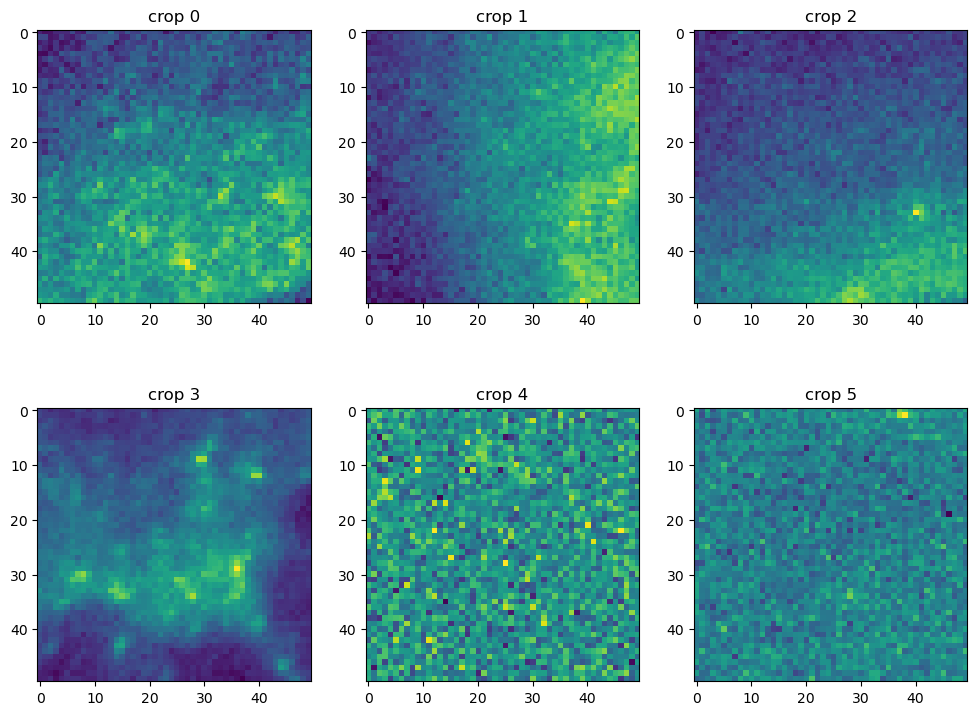

In [6]:
# create 50 x 50 crops from the input image (note that these slices are Java objects)
crops = [
    data[318: 368, 369: 419], # crop 0
    data[130: 180, 355: 405], # crop 1
    data[87: 137, 194: 244],  # crop 2
    data[263: 313, 43: 93],   # crop 3
    data[19: 69, 57: 107],    # crop 4
    data[263: 313, 221: 271]  # crop 5
]

# store the min x and min y values to draw crop boxes
crop_coords = [
    (318, 369),
    (130, 355),
    (87, 194),
    (263, 43),
    (19, 57),
    (263, 221)
]

# view the crops in a 2 x 3 grid in matplotlib
fig, ax = plt.subplots(2, 3, figsize=(12, 9))
ax[0, 0].imshow(ij.py.from_java(crops[0]))
ax[0, 0].set_title("crop 0")
ax[0, 1].imshow(ij.py.from_java(crops[1]))
ax[0, 1].set_title("crop 1")
ax[0, 2].imshow(ij.py.from_java(crops[2]))
ax[0, 2].set_title("crop 2")
ax[1, 0].imshow(ij.py.from_java(crops[3]))
ax[1, 0].set_title("crop 3")
ax[1, 1].imshow(ij.py.from_java(crops[4]))
ax[1, 1].set_title("crop 4")
ax[1, 2].imshow(ij.py.from_java(crops[5]))
ax[1, 2].set_title("crop 5")

# display the 2 x 3 image grid
plt.show()

Viewing the crops in a 2 x 3 grid is helpful, but its hard to determine where these particular crops are extracted from in the original image. The next cell will display the original input image with red boxes indicating the location each crop was extracted from.

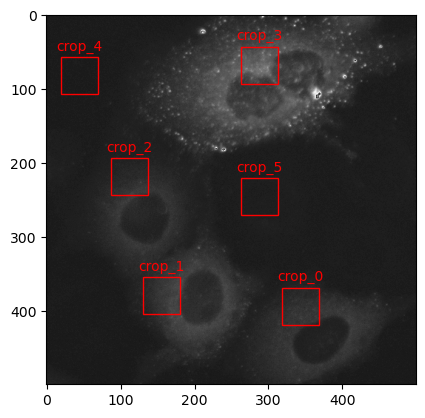

In [7]:
# display the original image (multiplied by 12 to increase it's brightness)
plt.imshow(data_xarr * 12, cmap='Greys_r')

# create red boxes for each crop on top of the original image
for i in range(len(crop_coords)):
    x = crop_coords[i][0]
    y = crop_coords[i][1]
    rect = patches.Rectangle((x, y), 50, 50, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    # add a label at the center of each rectangle
    plt.text(x + 25, y - 15, f"crop_{i}", color='r', ha='center', va='center')

# display the original image with red crop boxes
plt.show()

Finally, we can now perform the _correlation_ and _difference variance_ GLCM texture analysis. This last cell uses the `process_crops()` function that we setup earlier, which processes each crop in the `crops` list with the `run_glcm()` function. The output `pandas.DataFrame` is then plotted on a matplotlib scatterplot.

In the resulting scatterplot we can clearly see that our crops clustered in descrete regions. Crops 0, 1 and 2 which all come from the cytoplasm of cells expressing mVenus-Gag at _below_ Gag multimerization threshold levels. Visually these crops appear smooth and invariant, thus accordingly they have a high GLCM _correlation_ value and a low GLCM _difference variance_ values. Crops 4 and 5 are extracted from the background. Interestingly, while they appear smooth they have a low GLCM _correlation_ value indicating they are infact **not homogenous. The _difference variance_ values for crops 4 and 5 suggests crop 4 is more variable in signal inensity than crop 5. Lastly crop 3, which was extracted from the cell at or above the Gag multimerization threshold (_i.e._ the cell is producing viral particles) has a lower _correlation_ score than crops 0-2 and higher than crops 4 and 5. This suggests that crop 3 is not as smooth as crops 0-2 but smoother than the background.

Overall by measuring the GLCM _correlation_ and _difference variance_ textures we can distinguish cells that are in the assembly stage of the viral life cycle and are producing viral particles and those that are not.

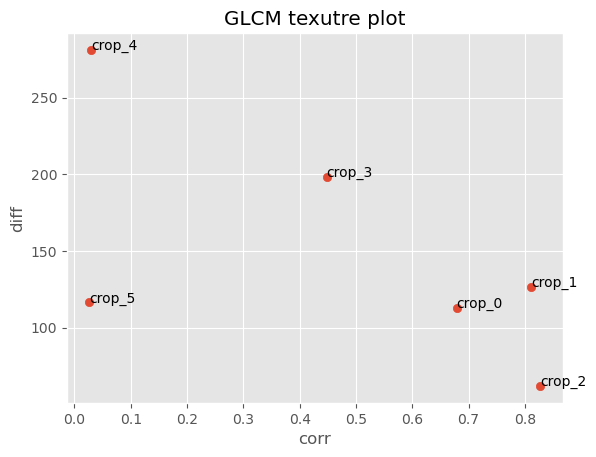

In [8]:
# set plot style
plt.style.use('ggplot')

# process the list of crops and plot them in a scatter plot
df = process_crops(crops, gray_levels, dist, "horizontal")
plt.scatter(df['corr'], df['diff'])

# add labels
for i in range(len(df)):
    plt.annotate(f"crop_{i}", (df['corr'][i], df['diff'][i]))

# add labels and title
plt.xlabel('corr')
plt.ylabel('diff')
plt.title('GLCM texutre plot')

plt.show()

With a distance value set to `10` pixels (so looking at broader patterns) we can see that crop_3 stands out.

## References

<sup>1</sup>: [Becker _et. al_, _J Virol_ 2017](https://pubmed.ncbi.nlm.nih.gov/28053097/)